In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle
import os

import sys
sys.path.append('../')
import plot_util
import util

In [2]:
# Note that we are loading the FULL signal and background datasets
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220301_ELReLMIs54_MUReLMIs31_btag77_VVZ.arrow')
sig['is_signal'] = True
bg = pd.read_feather(('/home/grabanal/WVZ/gabriel_ML_data/'
                           + '20220301_ELReLMIs54_MUReLMIs31_btag77_FULLBG.arrow'))
bg['is_signal'] = False

In [3]:
train_feats = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 
                                                          'v_j_btag77', 'v_j_btag60', 
                                                          'v_j_btag85', 'v_j_btagCont', 'v_j_btag70']])
print('Using the following training features:')
print(sorted(train_feats))

Using the following training features:
['HT', 'MET', 'METPhi', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_ambiguous', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_ambiguous', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zcand_mass', 'Zlep1_ambiguous', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_ambiguous', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'chisq', 'eta_1', 'eta_2', 'eta_3', 'eta_4', 'jet_btagCont_1', 'jet_btagCont_2', 'jet_btagCont_3', 'jet_btagCont_4', 'jet_eta_1', 'jet_eta_2', 'jet_eta_3', 'jet_eta_4', 'jet_m_1', 'jet_m_2', 'jet_m_3', 'jet_m_4', 'jet_phi_1', 'jet_phi_2', 'jet_phi_3', 'jet_phi_4', 'jet_pt_1', 'jet_pt_2', 'jet_pt_3', 'jet_pt_4', 'lep1_ambiguous', 'lep1_pid', 'lep2_ambiguous', 'lep2_pid', 'lep3_ambiguous', 'lep3_pid', 'lep4_ambiguous', 'lep4_pid', 'leptonic_HT', 'mass_4l', 'other_mass', 'phi_1', 'phi_2', 'phi_3', 'phi_4', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'tota

In [4]:
# Normalize training features
X = pd.concat([sig[train_feats], bg[train_feats]], ignore_index=True)

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg]:
    df[train_feats] = min_max_scaler.transform(df[train_feats])

In [5]:
# Cut to 4l-SF (no Z) signal region
bg = bg[bg.SR == 0.5]
sig = sig[sig.SR == 0.5]

# Setup k-folds

In [6]:
combined_data = pd.concat([sig[train_feats + ['wgt', 'is_signal']], bg[train_feats + ['wgt', 'is_signal']]], 
                          ignore_index=True)
combined_labels = np.concatenate([np.ones(len(sig)), np.zeros(len(bg))])

In [7]:
K_FOLDS = 5
k_folder = StratifiedKFold(n_splits = K_FOLDS, random_state=314, shuffle=True)

# Assign k-folds
combined_data['k_fold'] = -1
for i, (_, test_index) in enumerate(k_folder.split(combined_data, combined_labels)):
    combined_data.loc[test_index, 'k_fold'] = i

# Train models

In [ ]:
EPOCHS = 10000
PATIENCE = 200
BATCH_SIZE = 512
NUM_NODES = 64
DROPOUT = 0.1
LEARN_RATE = 1e-5

def make_model(input_dim, num_nodes, dropout, learn_rate):
    # Generate and fit model
    K.clear_session()
    classifier = Sequential()
    classifier.add(Dense(num_nodes, input_dim=input_dim, activation='relu')) 
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return classifier

models = [None] * K_FOLDS

for k in range(K_FOLDS):
    # Generate train and validation samples
    # The test sample has k-index k
    # The validation sample has k-index k - 1
    # The rest is for training
    val_k_index = k - 1
    if val_k_index < 0:
        val_k_index = K_FOLDS - 1
        
    x_val = combined_data[combined_data.k_fold == val_k_index]
    y_val = combined_labels[combined_data.k_fold == val_k_index]
    w_val = np.abs(x_val.wgt)
    
    x_train = combined_data[(combined_data.k_fold != k)&(combined_data.k_fold != val_k_index)]
    y_train = combined_labels[(combined_data.k_fold != k)&(combined_data.k_fold != val_k_index)]
    
    n_train_sig = sum(x_train[y_train == 1].wgt)
    n_train_bg = sum(x_train[y_train == 0].wgt)
    
    sig_correction = (n_train_sig + n_train_bg) / (2 * n_train_sig)
    bg_correction = (n_train_sig + n_train_bg) / (2 * n_train_bg)
    w_train = (sig_correction * y_train + bg_correction * (1 - y_train)) * np.abs(x_train.wgt)
    
    # Restrict to training features
    x_train = x_train[train_feats]
    x_val = x_val[train_feats]
    
    # Generate and fit model
    classifier = make_model(input_dim=x_train.shape[1], num_nodes=NUM_NODES, 
                            dropout=DROPOUT, learn_rate=LEARN_RATE)
    
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, 
                                                   restore_best_weights=True)

    history = classifier.fit(x_train, y_train, sample_weight=w_train, 
                             validation_data=(x_val, y_val, w_val),
                             epochs=EPOCHS, batch_size=BATCH_SIZE,
                             verbose=1, callbacks=[es_callback], shuffle=True)
    
    # Save model and history
    model_dir = 'models/SR_SF_noZ/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    classifier.save(model_dir + model_name)
    with open(model_dir + model_name + '_history.pkl', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Epoch 1/10000
512/512 [==============================] - 3s 5ms/step - loss: 0.0013 - accuracy: 0.9188 - val_loss: 0.0012 - val_accuracy: 0.9451
Epoch 2/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 0.9279 - val_loss: 0.0012 - val_accuracy: 0.9433
Epoch 3/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 0.9206 - val_loss: 0.0011 - val_accuracy: 0.9391
Epoch 4/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 0.9106 - val_loss: 0.0011 - val_accuracy: 0.9225
Epoch 5/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 0.8901 - val_loss: 0.0011 - val_accuracy: 0.8929
Epoch 6/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 0.8695 - val_loss: 0.0011 - val_accuracy: 0.8580
Epoch 7/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 0.8459 - val_loss: 0.0011 - val_ac

Epoch 112/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7354 - val_loss: 9.5539e-04 - val_accuracy: 0.7361
Epoch 113/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7317 - val_loss: 9.5031e-04 - val_accuracy: 0.7379
Epoch 114/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7345 - val_loss: 9.7175e-04 - val_accuracy: 0.7299
Epoch 115/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7350 - val_loss: 9.6968e-04 - val_accuracy: 0.7298
Epoch 116/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7277 - val_loss: 9.7018e-04 - val_accuracy: 0.7299
Epoch 117/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7299 - val_loss: 9.4803e-04 - val_accuracy: 0.7383
Epoch 118/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accura

512/512 [==============================] - 2s 5ms/step - loss: 9.9044e-04 - accuracy: 0.7319 - val_loss: 9.0704e-04 - val_accuracy: 0.7270
Epoch 221/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.7206 - val_loss: 8.9585e-04 - val_accuracy: 0.7303
Epoch 222/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.7260 - val_loss: 9.2597e-04 - val_accuracy: 0.7198
Epoch 223/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.7838e-04 - accuracy: 0.7284 - val_loss: 9.2792e-04 - val_accuracy: 0.7195
Epoch 224/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.7221 - val_loss: 8.8011e-04 - val_accuracy: 0.7360
Epoch 225/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.9738e-04 - accuracy: 0.7313 - val_loss: 8.9472e-04 - val_accuracy: 0.7305
Epoch 226/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.9615e-04 - accura

Epoch 326/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.7191e-04 - accuracy: 0.7211 - val_loss: 8.6270e-04 - val_accuracy: 0.7290
Epoch 327/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.5106e-04 - accuracy: 0.7253 - val_loss: 8.5203e-04 - val_accuracy: 0.7324
Epoch 328/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.5103e-04 - accuracy: 0.7274 - val_loss: 8.5988e-04 - val_accuracy: 0.7299
Epoch 329/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.5560e-04 - accuracy: 0.7263 - val_loss: 8.5592e-04 - val_accuracy: 0.7308
Epoch 330/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.7157e-04 - accuracy: 0.7233 - val_loss: 8.5211e-04 - val_accuracy: 0.7319
Epoch 331/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.5459e-04 - accuracy: 0.7261 - val_loss: 8.5609e-04 - val_accuracy: 0.7302
Epoch 332/10000
512/512 [==============================] - 2s 5ms/step

Epoch 379/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.4744e-04 - accuracy: 0.7218 - val_loss: 8.2687e-04 - val_accuracy: 0.7358
Epoch 380/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.1203e-04 - accuracy: 0.7326 - val_loss: 8.5655e-04 - val_accuracy: 0.7267
Epoch 381/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.2850e-04 - accuracy: 0.7244 - val_loss: 8.3995e-04 - val_accuracy: 0.7316
Epoch 382/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.2735e-04 - accuracy: 0.7299 - val_loss: 8.1901e-04 - val_accuracy: 0.7379
Epoch 383/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.3938e-04 - accuracy: 0.7267 - val_loss: 8.2609e-04 - val_accuracy: 0.7351
Epoch 384/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.2741e-04 - accuracy: 0.7268 - val_loss: 8.0470e-04 - val_accuracy: 0.7419
Epoch 385/10000
512/512 [==============================] - 2s 5ms/step

Epoch 432/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.0737e-04 - accuracy: 0.7287 - val_loss: 8.2806e-04 - val_accuracy: 0.7334
Epoch 433/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.0828e-04 - accuracy: 0.7318 - val_loss: 8.0604e-04 - val_accuracy: 0.7400
Epoch 434/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.0694e-04 - accuracy: 0.7328 - val_loss: 8.1498e-04 - val_accuracy: 0.7381
Epoch 435/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.9475e-04 - accuracy: 0.7338 - val_loss: 8.1166e-04 - val_accuracy: 0.7387
Epoch 436/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.0585e-04 - accuracy: 0.7327 - val_loss: 8.0507e-04 - val_accuracy: 0.7413
Epoch 437/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.0201e-04 - accuracy: 0.7348 - val_loss: 8.1631e-04 - val_accuracy: 0.7384
Epoch 438/10000
512/512 [==============================] - 2s 5ms/step

Epoch 485/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.7851e-04 - accuracy: 0.7398 - val_loss: 7.8501e-04 - val_accuracy: 0.7466
Epoch 486/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.7882e-04 - accuracy: 0.7392 - val_loss: 7.8879e-04 - val_accuracy: 0.7457
Epoch 487/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.7257e-04 - accuracy: 0.7390 - val_loss: 7.8104e-04 - val_accuracy: 0.7483
Epoch 488/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.8342e-04 - accuracy: 0.7358 - val_loss: 7.6523e-04 - val_accuracy: 0.7527
Epoch 489/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.6194e-04 - accuracy: 0.7450 - val_loss: 7.8507e-04 - val_accuracy: 0.7469
Epoch 490/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.8817e-04 - accuracy: 0.7376 - val_loss: 7.4205e-04 - val_accuracy: 0.7598
Epoch 491/10000
512/512 [==============================] - 2s 5ms/step

Epoch 538/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.6113e-04 - accuracy: 0.7439 - val_loss: 7.6062e-04 - val_accuracy: 0.7541
Epoch 539/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.4248e-04 - accuracy: 0.7458 - val_loss: 7.6465e-04 - val_accuracy: 0.7533
Epoch 540/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.4942e-04 - accuracy: 0.7452 - val_loss: 7.5583e-04 - val_accuracy: 0.7553
Epoch 541/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.6127e-04 - accuracy: 0.7427 - val_loss: 7.2765e-04 - val_accuracy: 0.7641
Epoch 542/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.4249e-04 - accuracy: 0.7486 - val_loss: 7.6076e-04 - val_accuracy: 0.7544
Epoch 543/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.4392e-04 - accuracy: 0.7447 - val_loss: 7.7754e-04 - val_accuracy: 0.7495
Epoch 544/10000
512/512 [==============================] - 2s 5ms/step

Epoch 591/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.3942e-04 - accuracy: 0.7516 - val_loss: 7.0300e-04 - val_accuracy: 0.7728
Epoch 592/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.3194e-04 - accuracy: 0.7574 - val_loss: 7.2218e-04 - val_accuracy: 0.7666
Epoch 593/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.2951e-04 - accuracy: 0.7593 - val_loss: 7.2194e-04 - val_accuracy: 0.7667
Epoch 594/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.3056e-04 - accuracy: 0.7550 - val_loss: 7.4812e-04 - val_accuracy: 0.7590
Epoch 595/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.2499e-04 - accuracy: 0.7546 - val_loss: 7.3739e-04 - val_accuracy: 0.7620
Epoch 596/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.3467e-04 - accuracy: 0.7526 - val_loss: 7.0646e-04 - val_accuracy: 0.7707
Epoch 597/10000
512/512 [==============================] - 2s 5ms/step

Epoch 644/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.0230e-04 - accuracy: 0.7625 - val_loss: 6.9875e-04 - val_accuracy: 0.7749
Epoch 645/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.0698e-04 - accuracy: 0.7630 - val_loss: 7.1120e-04 - val_accuracy: 0.7724
Epoch 646/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.0154e-04 - accuracy: 0.7620 - val_loss: 6.7700e-04 - val_accuracy: 0.7814
Epoch 647/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.0584e-04 - accuracy: 0.7640 - val_loss: 6.9005e-04 - val_accuracy: 0.7787
Epoch 648/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.1536e-04 - accuracy: 0.7652 - val_loss: 6.9562e-04 - val_accuracy: 0.7767
Epoch 649/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.8944e-04 - accuracy: 0.7679 - val_loss: 7.1451e-04 - val_accuracy: 0.7714
Epoch 650/10000
512/512 [==============================] - 2s 5ms/step

Epoch 697/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.9482e-04 - accuracy: 0.7701 - val_loss: 7.0100e-04 - val_accuracy: 0.7768
Epoch 698/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.9847e-04 - accuracy: 0.7674 - val_loss: 6.6292e-04 - val_accuracy: 0.7885
Epoch 699/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.7735e-04 - accuracy: 0.7717 - val_loss: 6.5343e-04 - val_accuracy: 0.7910
Epoch 700/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.8326e-04 - accuracy: 0.7721 - val_loss: 6.7294e-04 - val_accuracy: 0.7854
Epoch 701/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.8753e-04 - accuracy: 0.7707 - val_loss: 6.6545e-04 - val_accuracy: 0.7871
Epoch 702/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.8085e-04 - accuracy: 0.7716 - val_loss: 6.6521e-04 - val_accuracy: 0.7886
Epoch 703/10000
512/512 [==============================] - 2s 5ms/step

Epoch 750/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.6567e-04 - accuracy: 0.7814 - val_loss: 6.4776e-04 - val_accuracy: 0.7949
Epoch 751/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.5689e-04 - accuracy: 0.7807 - val_loss: 6.5239e-04 - val_accuracy: 0.7927
Epoch 752/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.6453e-04 - accuracy: 0.7792 - val_loss: 6.3128e-04 - val_accuracy: 0.7998
Epoch 753/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.5289e-04 - accuracy: 0.7826 - val_loss: 6.6785e-04 - val_accuracy: 0.7883
Epoch 754/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.5964e-04 - accuracy: 0.7771 - val_loss: 6.4554e-04 - val_accuracy: 0.7959
Epoch 755/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.6927e-04 - accuracy: 0.7808 - val_loss: 6.4456e-04 - val_accuracy: 0.7967
Epoch 756/10000
512/512 [==============================] - 2s 5ms/step

Epoch 803/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.5081e-04 - accuracy: 0.7888 - val_loss: 6.2828e-04 - val_accuracy: 0.8037
Epoch 804/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.3377e-04 - accuracy: 0.7895 - val_loss: 6.3246e-04 - val_accuracy: 0.8029
Epoch 805/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.4513e-04 - accuracy: 0.7887 - val_loss: 6.3426e-04 - val_accuracy: 0.8020
Epoch 806/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.5674e-04 - accuracy: 0.7849 - val_loss: 6.2803e-04 - val_accuracy: 0.8050
Epoch 807/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.4272e-04 - accuracy: 0.7874 - val_loss: 6.0947e-04 - val_accuracy: 0.8094
Epoch 808/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.5150e-04 - accuracy: 0.7885 - val_loss: 6.4421e-04 - val_accuracy: 0.7997
Epoch 809/10000
512/512 [==============================] - 2s 5ms/step

Epoch 856/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.2671e-04 - accuracy: 0.7931 - val_loss: 6.2314e-04 - val_accuracy: 0.8069
Epoch 857/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.3086e-04 - accuracy: 0.7936 - val_loss: 5.9828e-04 - val_accuracy: 0.8151
Epoch 858/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.3371e-04 - accuracy: 0.7966 - val_loss: 6.0327e-04 - val_accuracy: 0.8134
Epoch 859/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.1785e-04 - accuracy: 0.7967 - val_loss: 6.1039e-04 - val_accuracy: 0.8113
Epoch 860/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.3804e-04 - accuracy: 0.7908 - val_loss: 6.1480e-04 - val_accuracy: 0.8097
Epoch 861/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.3103e-04 - accuracy: 0.7941 - val_loss: 6.3254e-04 - val_accuracy: 0.8045
Epoch 862/10000
512/512 [==============================] - 2s 5ms/step

Epoch 909/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.0817e-04 - accuracy: 0.8000 - val_loss: 5.9368e-04 - val_accuracy: 0.8182
Epoch 910/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.0027e-04 - accuracy: 0.8021 - val_loss: 6.0744e-04 - val_accuracy: 0.8154
Epoch 911/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.2130e-04 - accuracy: 0.8023 - val_loss: 5.8698e-04 - val_accuracy: 0.8208
Epoch 912/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.1673e-04 - accuracy: 0.8017 - val_loss: 5.8386e-04 - val_accuracy: 0.8220
Epoch 913/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.0624e-04 - accuracy: 0.8045 - val_loss: 6.0769e-04 - val_accuracy: 0.8152
Epoch 914/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.1542e-04 - accuracy: 0.7996 - val_loss: 5.9750e-04 - val_accuracy: 0.8181
Epoch 915/10000
512/512 [==============================] - 2s 5ms/step

Epoch 962/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.9846e-04 - accuracy: 0.8045 - val_loss: 5.6388e-04 - val_accuracy: 0.8296
Epoch 963/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.1043e-04 - accuracy: 0.8069 - val_loss: 5.8802e-04 - val_accuracy: 0.8221
Epoch 964/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.9798e-04 - accuracy: 0.8061 - val_loss: 5.9382e-04 - val_accuracy: 0.8200
Epoch 965/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.0614e-04 - accuracy: 0.8027 - val_loss: 5.8222e-04 - val_accuracy: 0.8235
Epoch 966/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.9931e-04 - accuracy: 0.8063 - val_loss: 5.7052e-04 - val_accuracy: 0.8269
Epoch 967/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.8770e-04 - accuracy: 0.8112 - val_loss: 5.7926e-04 - val_accuracy: 0.8246
Epoch 968/10000
512/512 [==============================] - 2s 5ms/step

Epoch 1015/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.9243e-04 - accuracy: 0.8088 - val_loss: 5.9508e-04 - val_accuracy: 0.8205
Epoch 1016/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.8968e-04 - accuracy: 0.8059 - val_loss: 5.6197e-04 - val_accuracy: 0.8307
Epoch 1017/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.7973e-04 - accuracy: 0.8137 - val_loss: 5.8042e-04 - val_accuracy: 0.8247
Epoch 1018/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.8264e-04 - accuracy: 0.8088 - val_loss: 5.8100e-04 - val_accuracy: 0.8240
Epoch 1019/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.8616e-04 - accuracy: 0.8068 - val_loss: 5.8922e-04 - val_accuracy: 0.8223
Epoch 1020/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.9296e-04 - accuracy: 0.8074 - val_loss: 6.0778e-04 - val_accuracy: 0.8166
Epoch 1021/10000
512/512 [==============================] - 2s 5

512/512 [==============================] - 2s 5ms/step - loss: 6.6291e-04 - accuracy: 0.8162 - val_loss: 5.8078e-04 - val_accuracy: 0.8250
Epoch 1120/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.6776e-04 - accuracy: 0.8131 - val_loss: 5.6940e-04 - val_accuracy: 0.8290
Epoch 1121/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.7055e-04 - accuracy: 0.8150 - val_loss: 5.7697e-04 - val_accuracy: 0.8276
Epoch 1122/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.7087e-04 - accuracy: 0.8127 - val_loss: 5.7532e-04 - val_accuracy: 0.8290
Epoch 1123/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.6314e-04 - accuracy: 0.8173 - val_loss: 5.6198e-04 - val_accuracy: 0.8319
Epoch 1124/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.6241e-04 - accuracy: 0.8168 - val_loss: 5.9449e-04 - val_accuracy: 0.8216
Epoch 1125/10000
512/512 [==============================] - 2s 5ms/step - loss: 6

512/512 [==============================] - 2s 4ms/step - loss: 6.6057e-04 - accuracy: 0.8174 - val_loss: 5.4481e-04 - val_accuracy: 0.8378
Epoch 1224/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.4024e-04 - accuracy: 0.8226 - val_loss: 5.6096e-04 - val_accuracy: 0.8334
Epoch 1225/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.5032e-04 - accuracy: 0.8220 - val_loss: 5.7990e-04 - val_accuracy: 0.8276
Epoch 1226/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.5733e-04 - accuracy: 0.8204 - val_loss: 5.5419e-04 - val_accuracy: 0.8353
Epoch 1227/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.5743e-04 - accuracy: 0.8197 - val_loss: 5.8435e-04 - val_accuracy: 0.8243
Epoch 1228/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.5185e-04 - accuracy: 0.8160 - val_loss: 5.8224e-04 - val_accuracy: 0.8259
Epoch 1229/10000
512/512 [==============================] - 2s 5ms/step - loss: 6

512/512 [==============================] - 2s 5ms/step - loss: 6.2810e-04 - accuracy: 0.8222 - val_loss: 5.6392e-04 - val_accuracy: 0.8335
Epoch 1328/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.4043e-04 - accuracy: 0.8239 - val_loss: 5.6991e-04 - val_accuracy: 0.8311
Epoch 1329/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.2809e-04 - accuracy: 0.8260 - val_loss: 5.4213e-04 - val_accuracy: 0.8390
Epoch 1330/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.4482e-04 - accuracy: 0.8242 - val_loss: 5.4057e-04 - val_accuracy: 0.8388
Epoch 1331/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.4605e-04 - accuracy: 0.8225 - val_loss: 5.3274e-04 - val_accuracy: 0.8427
Epoch 1332/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.2284e-04 - accuracy: 0.8286 - val_loss: 5.6975e-04 - val_accuracy: 0.8313
Epoch 1333/10000
512/512 [==============================] - 2s 5ms/step - loss: 6

512/512 [==============================] - 2s 5ms/step - loss: 6.2563e-04 - accuracy: 0.8269 - val_loss: 5.3453e-04 - val_accuracy: 0.8417
Epoch 1432/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.1907e-04 - accuracy: 0.8304 - val_loss: 5.7209e-04 - val_accuracy: 0.8303
Epoch 1433/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.2540e-04 - accuracy: 0.8255 - val_loss: 5.5096e-04 - val_accuracy: 0.8365
Epoch 1434/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.3230e-04 - accuracy: 0.8251 - val_loss: 5.3804e-04 - val_accuracy: 0.8392
Epoch 1435/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.2364e-04 - accuracy: 0.8288 - val_loss: 5.7806e-04 - val_accuracy: 0.8292
Epoch 1436/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.2742e-04 - accuracy: 0.8241 - val_loss: 5.3400e-04 - val_accuracy: 0.8412
Epoch 1437/10000
512/512 [==============================] - 2s 5ms/step - loss: 6

512/512 [==============================] - 2s 5ms/step - loss: 6.1645e-04 - accuracy: 0.8273 - val_loss: 5.3292e-04 - val_accuracy: 0.8421
Epoch 1536/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.1896e-04 - accuracy: 0.8270 - val_loss: 5.4128e-04 - val_accuracy: 0.8397
Epoch 1537/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.2400e-04 - accuracy: 0.8283 - val_loss: 5.4512e-04 - val_accuracy: 0.8377
Epoch 1538/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.1735e-04 - accuracy: 0.8274 - val_loss: 5.6664e-04 - val_accuracy: 0.8313
Epoch 1539/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.1811e-04 - accuracy: 0.8250 - val_loss: 5.3227e-04 - val_accuracy: 0.8419
Epoch 1540/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.1537e-04 - accuracy: 0.8304 - val_loss: 5.4984e-04 - val_accuracy: 0.8375
Epoch 1541/10000
512/512 [==============================] - 2s 5ms/step - loss: 6

512/512 [==============================] - 2s 5ms/step - loss: 6.1107e-04 - accuracy: 0.8297 - val_loss: 5.3986e-04 - val_accuracy: 0.8409
Epoch 1640/10000
512/512 [==============================] - 2s 5ms/step - loss: 5.9527e-04 - accuracy: 0.8319 - val_loss: 5.4225e-04 - val_accuracy: 0.8404
Epoch 1641/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.1370e-04 - accuracy: 0.8293 - val_loss: 5.2404e-04 - val_accuracy: 0.8459
Epoch 1642/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.1020e-04 - accuracy: 0.8315 - val_loss: 5.2655e-04 - val_accuracy: 0.8445
Epoch 1643/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.0059e-04 - accuracy: 0.8340 - val_loss: 5.6872e-04 - val_accuracy: 0.8314
Epoch 1644/10000
512/512 [==============================] - 2s 5ms/step - loss: 5.9332e-04 - accuracy: 0.8279 - val_loss: 5.3268e-04 - val_accuracy: 0.8425
Epoch 1645/10000
512/512 [==============================] - 2s 5ms/step - loss: 6

512/512 [==============================] - 2s 5ms/step - loss: 6.0287e-04 - accuracy: 0.8304 - val_loss: 5.3775e-04 - val_accuracy: 0.8413
Epoch 1744/10000
512/512 [==============================] - 2s 5ms/step - loss: 5.9290e-04 - accuracy: 0.8354 - val_loss: 5.4726e-04 - val_accuracy: 0.8384
Epoch 1745/10000
512/512 [==============================] - 2s 5ms/step - loss: 5.9239e-04 - accuracy: 0.8348 - val_loss: 5.1783e-04 - val_accuracy: 0.8472
Epoch 1746/10000
512/512 [==============================] - 2s 4ms/step - loss: 6.0276e-04 - accuracy: 0.8334 - val_loss: 5.2878e-04 - val_accuracy: 0.8441
Epoch 1747/10000
512/512 [==============================] - 2s 5ms/step - loss: 5.9141e-04 - accuracy: 0.8339 - val_loss: 5.6073e-04 - val_accuracy: 0.8356
Epoch 1748/10000
512/512 [==============================] - 2s 5ms/step - loss: 5.9420e-04 - accuracy: 0.8328 - val_loss: 5.3611e-04 - val_accuracy: 0.8420
Epoch 1749/10000
512/512 [==============================] - 2s 5ms/step - loss: 6

512/512 [==============================] - 2s 5ms/step - loss: 5.8564e-04 - accuracy: 0.8375 - val_loss: 5.3902e-04 - val_accuracy: 0.8419
Epoch 1848/10000
512/512 [==============================] - 2s 5ms/step - loss: 5.9893e-04 - accuracy: 0.8331 - val_loss: 5.2066e-04 - val_accuracy: 0.8472
Epoch 1849/10000
512/512 [==============================] - 2s 5ms/step - loss: 5.9235e-04 - accuracy: 0.8364 - val_loss: 5.2317e-04 - val_accuracy: 0.8476
Epoch 1850/10000
512/512 [==============================] - 2s 5ms/step - loss: 5.9636e-04 - accuracy: 0.8362 - val_loss: 5.2538e-04 - val_accuracy: 0.8462
Epoch 1851/10000
512/512 [==============================] - 2s 5ms/step - loss: 5.7989e-04 - accuracy: 0.8390 - val_loss: 5.4219e-04 - val_accuracy: 0.8414
Epoch 1852/10000
512/512 [==============================] - 2s 5ms/step - loss: 5.9022e-04 - accuracy: 0.8361 - val_loss: 5.2644e-04 - val_accuracy: 0.8456
Epoch 1853/10000
512/512 [==============================] - 2s 5ms/step - loss: 5

2022-03-10 17:59:15.864557: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/SR_SF_noZ/classifier_abs_wgt_k_0/assets
Epoch 1/10000
512/512 [==============================] - 3s 5ms/step - loss: 0.0013 - accuracy: 0.9460 - val_loss: 0.0012 - val_accuracy: 0.9457
Epoch 2/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 0.9466 - val_loss: 0.0012 - val_accuracy: 0.9457
Epoch 3/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 0.9452 - val_loss: 0.0012 - val_accuracy: 0.9457
Epoch 4/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 0.9454 - val_loss: 0.0012 - val_accuracy: 0.9457
Epoch 5/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 0.9455 - val_loss: 0.0012 - val_accuracy: 0.9457
Epoch 6/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0013 - accuracy: 0.9454 - val_loss: 0.0012 - val_accuracy: 0.9456
Epoch 7/10000
512/512 [=========================

Epoch 112/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7294 - val_loss: 0.0010 - val_accuracy: 0.7201
Epoch 113/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7287 - val_loss: 0.0010 - val_accuracy: 0.7202
Epoch 114/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7246 - val_loss: 9.9131e-04 - val_accuracy: 0.7257
Epoch 115/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7286 - val_loss: 9.8149e-04 - val_accuracy: 0.7287
Epoch 116/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7295 - val_loss: 0.0010 - val_accuracy: 0.7209
Epoch 117/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7287 - val_loss: 0.0010 - val_accuracy: 0.7186
Epoch 118/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0011 - accuracy: 0.7282 - val

512/512 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.7231 - val_loss: 9.3311e-04 - val_accuracy: 0.7191
Epoch 221/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.7192 - val_loss: 9.3496e-04 - val_accuracy: 0.7178
Epoch 222/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.7119 - val_loss: 9.2545e-04 - val_accuracy: 0.7214
Epoch 223/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.7209 - val_loss: 9.2671e-04 - val_accuracy: 0.7207
Epoch 224/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.7140 - val_loss: 9.0379e-04 - val_accuracy: 0.7281
Epoch 225/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.7246 - val_loss: 9.3400e-04 - val_accuracy: 0.7165
Epoch 226/10000
512/512 [==============================] - 2s 5ms/step - loss: 0.0010 - accuracy: 0.7111 - val

512/512 [==============================] - 2s 5ms/step - loss: 9.7789e-04 - accuracy: 0.7175 - val_loss: 8.8851e-04 - val_accuracy: 0.7179
Epoch 328/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.7681e-04 - accuracy: 0.7147 - val_loss: 9.0033e-04 - val_accuracy: 0.7143
Epoch 329/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.6651e-04 - accuracy: 0.7126 - val_loss: 9.0239e-04 - val_accuracy: 0.7134
Epoch 330/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.8592e-04 - accuracy: 0.7088 - val_loss: 8.7991e-04 - val_accuracy: 0.7209
Epoch 331/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.7355e-04 - accuracy: 0.7151 - val_loss: 8.6345e-04 - val_accuracy: 0.7258
Epoch 332/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.5699e-04 - accuracy: 0.7208 - val_loss: 8.9234e-04 - val_accuracy: 0.7164
Epoch 333/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.6889e

Epoch 380/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.4591e-04 - accuracy: 0.7176 - val_loss: 8.6287e-04 - val_accuracy: 0.7216
Epoch 381/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.5443e-04 - accuracy: 0.7165 - val_loss: 8.5716e-04 - val_accuracy: 0.7236
Epoch 382/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.5275e-04 - accuracy: 0.7166 - val_loss: 8.4379e-04 - val_accuracy: 0.7268
Epoch 383/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.5724e-04 - accuracy: 0.7164 - val_loss: 8.6729e-04 - val_accuracy: 0.7205
Epoch 384/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.5657e-04 - accuracy: 0.7124 - val_loss: 8.4010e-04 - val_accuracy: 0.7288
Epoch 385/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.5316e-04 - accuracy: 0.7195 - val_loss: 8.4631e-04 - val_accuracy: 0.7269
Epoch 386/10000
512/512 [==============================] - 2s 5ms/step

Epoch 433/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.2822e-04 - accuracy: 0.7162 - val_loss: 8.2431e-04 - val_accuracy: 0.7303
Epoch 434/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.4582e-04 - accuracy: 0.7182 - val_loss: 8.2308e-04 - val_accuracy: 0.7319
Epoch 435/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.2836e-04 - accuracy: 0.7221 - val_loss: 8.3373e-04 - val_accuracy: 0.7280
Epoch 436/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.3102e-04 - accuracy: 0.7199 - val_loss: 8.1818e-04 - val_accuracy: 0.7325
Epoch 437/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.3609e-04 - accuracy: 0.7193 - val_loss: 8.3450e-04 - val_accuracy: 0.7276
Epoch 438/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.1980e-04 - accuracy: 0.7193 - val_loss: 8.4260e-04 - val_accuracy: 0.7255
Epoch 439/10000
512/512 [==============================] - 2s 5ms/step

Epoch 486/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.0882e-04 - accuracy: 0.7259 - val_loss: 7.7958e-04 - val_accuracy: 0.7446
Epoch 487/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.0518e-04 - accuracy: 0.7290 - val_loss: 8.5167e-04 - val_accuracy: 0.7215
Epoch 488/10000
512/512 [==============================] - 2s 4ms/step - loss: 8.9781e-04 - accuracy: 0.7225 - val_loss: 8.1093e-04 - val_accuracy: 0.7352
Epoch 489/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.2145e-04 - accuracy: 0.7225 - val_loss: 7.8951e-04 - val_accuracy: 0.7418
Epoch 490/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.0861e-04 - accuracy: 0.7239 - val_loss: 7.9919e-04 - val_accuracy: 0.7387
Epoch 491/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.0131e-04 - accuracy: 0.7286 - val_loss: 8.1228e-04 - val_accuracy: 0.7348
Epoch 492/10000
512/512 [==============================] - 2s 5ms/step

Epoch 539/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.7673e-04 - accuracy: 0.7329 - val_loss: 7.8959e-04 - val_accuracy: 0.7432
Epoch 540/10000
512/512 [==============================] - 2s 5ms/step - loss: 9.0069e-04 - accuracy: 0.7274 - val_loss: 7.6252e-04 - val_accuracy: 0.7515
Epoch 541/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.9273e-04 - accuracy: 0.7358 - val_loss: 7.9032e-04 - val_accuracy: 0.7417
Epoch 542/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.8527e-04 - accuracy: 0.7310 - val_loss: 7.6297e-04 - val_accuracy: 0.7498
Epoch 543/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.7929e-04 - accuracy: 0.7338 - val_loss: 7.8127e-04 - val_accuracy: 0.7456
Epoch 544/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.9963e-04 - accuracy: 0.7308 - val_loss: 7.9260e-04 - val_accuracy: 0.7414
Epoch 545/10000
512/512 [==============================] - 2s 5ms/step

Epoch 592/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.5980e-04 - accuracy: 0.7391 - val_loss: 7.5980e-04 - val_accuracy: 0.7541
Epoch 593/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.5548e-04 - accuracy: 0.7388 - val_loss: 7.3456e-04 - val_accuracy: 0.7606
Epoch 594/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.5730e-04 - accuracy: 0.7401 - val_loss: 7.2888e-04 - val_accuracy: 0.7630
Epoch 595/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.6238e-04 - accuracy: 0.7393 - val_loss: 7.2795e-04 - val_accuracy: 0.7634
Epoch 596/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.5444e-04 - accuracy: 0.7438 - val_loss: 7.6851e-04 - val_accuracy: 0.7519
Epoch 597/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.4576e-04 - accuracy: 0.7408 - val_loss: 7.5026e-04 - val_accuracy: 0.7569
Epoch 598/10000
512/512 [==============================] - 2s 5ms/step

Epoch 645/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.3131e-04 - accuracy: 0.7502 - val_loss: 7.1451e-04 - val_accuracy: 0.7684
Epoch 646/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.4131e-04 - accuracy: 0.7499 - val_loss: 7.5533e-04 - val_accuracy: 0.7564
Epoch 647/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.4511e-04 - accuracy: 0.7422 - val_loss: 7.1582e-04 - val_accuracy: 0.7687
Epoch 648/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.5144e-04 - accuracy: 0.7469 - val_loss: 7.4353e-04 - val_accuracy: 0.7614
Epoch 649/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.3030e-04 - accuracy: 0.7495 - val_loss: 7.2475e-04 - val_accuracy: 0.7659
Epoch 650/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.3613e-04 - accuracy: 0.7479 - val_loss: 7.2161e-04 - val_accuracy: 0.7678
Epoch 651/10000
512/512 [==============================] - 2s 5ms/step

Epoch 698/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.0496e-04 - accuracy: 0.7578 - val_loss: 6.8384e-04 - val_accuracy: 0.7799
Epoch 699/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.2046e-04 - accuracy: 0.7585 - val_loss: 6.8724e-04 - val_accuracy: 0.7793
Epoch 700/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.0088e-04 - accuracy: 0.7607 - val_loss: 7.1679e-04 - val_accuracy: 0.7713
Epoch 701/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.0578e-04 - accuracy: 0.7580 - val_loss: 7.0250e-04 - val_accuracy: 0.7750
Epoch 702/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.1417e-04 - accuracy: 0.7563 - val_loss: 6.8600e-04 - val_accuracy: 0.7797
Epoch 703/10000
512/512 [==============================] - 2s 5ms/step - loss: 8.0977e-04 - accuracy: 0.7613 - val_loss: 6.8378e-04 - val_accuracy: 0.7804
Epoch 704/10000
512/512 [==============================] - 2s 5ms/step

Epoch 751/10000
512/512 [==============================] - 2s 4ms/step - loss: 7.9852e-04 - accuracy: 0.7715 - val_loss: 6.8578e-04 - val_accuracy: 0.7830
Epoch 752/10000
512/512 [==============================] - 2s 4ms/step - loss: 7.8592e-04 - accuracy: 0.7661 - val_loss: 6.8633e-04 - val_accuracy: 0.7831
Epoch 753/10000
512/512 [==============================] - 2s 4ms/step - loss: 7.9999e-04 - accuracy: 0.7659 - val_loss: 6.7213e-04 - val_accuracy: 0.7873
Epoch 754/10000
512/512 [==============================] - 2s 4ms/step - loss: 8.0154e-04 - accuracy: 0.7643 - val_loss: 6.5399e-04 - val_accuracy: 0.7926
Epoch 755/10000
512/512 [==============================] - 2s 4ms/step - loss: 7.9201e-04 - accuracy: 0.7672 - val_loss: 7.0463e-04 - val_accuracy: 0.7781
Epoch 756/10000
512/512 [==============================] - 2s 4ms/step - loss: 7.9729e-04 - accuracy: 0.7640 - val_loss: 6.7819e-04 - val_accuracy: 0.7861
Epoch 757/10000
512/512 [==============================] - 2s 4ms/step

Epoch 804/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.7263e-04 - accuracy: 0.7752 - val_loss: 6.2545e-04 - val_accuracy: 0.8033
Epoch 805/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.7439e-04 - accuracy: 0.7761 - val_loss: 6.3502e-04 - val_accuracy: 0.8004
Epoch 806/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.7399e-04 - accuracy: 0.7756 - val_loss: 6.5771e-04 - val_accuracy: 0.7937
Epoch 807/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.8037e-04 - accuracy: 0.7706 - val_loss: 6.2761e-04 - val_accuracy: 0.8032
Epoch 808/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.6219e-04 - accuracy: 0.7816 - val_loss: 6.4630e-04 - val_accuracy: 0.7974
Epoch 809/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.7797e-04 - accuracy: 0.7764 - val_loss: 6.5884e-04 - val_accuracy: 0.7936
Epoch 810/10000
512/512 [==============================] - 2s 5ms/step

Epoch 857/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.6239e-04 - accuracy: 0.7784 - val_loss: 6.1523e-04 - val_accuracy: 0.8087
Epoch 858/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.4074e-04 - accuracy: 0.7868 - val_loss: 6.5426e-04 - val_accuracy: 0.7973
Epoch 859/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.4987e-04 - accuracy: 0.7798 - val_loss: 6.0070e-04 - val_accuracy: 0.8137
Epoch 860/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.5515e-04 - accuracy: 0.7849 - val_loss: 6.0556e-04 - val_accuracy: 0.8114
Epoch 861/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.4718e-04 - accuracy: 0.7876 - val_loss: 6.2424e-04 - val_accuracy: 0.8056
Epoch 862/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.5213e-04 - accuracy: 0.7823 - val_loss: 6.2582e-04 - val_accuracy: 0.8063
Epoch 863/10000
512/512 [==============================] - 2s 5ms/step

Epoch 910/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.3459e-04 - accuracy: 0.7897 - val_loss: 6.1744e-04 - val_accuracy: 0.8107
Epoch 911/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.5079e-04 - accuracy: 0.7887 - val_loss: 5.9806e-04 - val_accuracy: 0.8161
Epoch 912/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.4083e-04 - accuracy: 0.7892 - val_loss: 5.7825e-04 - val_accuracy: 0.8214
Epoch 913/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.2987e-04 - accuracy: 0.7963 - val_loss: 6.1895e-04 - val_accuracy: 0.8098
Epoch 914/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.4261e-04 - accuracy: 0.7874 - val_loss: 6.0550e-04 - val_accuracy: 0.8141
Epoch 915/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.3305e-04 - accuracy: 0.7933 - val_loss: 5.8162e-04 - val_accuracy: 0.8211
Epoch 916/10000
512/512 [==============================] - 2s 5ms/step

Epoch 963/10000
512/512 [==============================] - 1s 2ms/step - loss: 7.1829e-04 - accuracy: 0.7962 - val_loss: 6.1672e-04 - val_accuracy: 0.8128
Epoch 964/10000
512/512 [==============================] - 1s 2ms/step - loss: 7.3132e-04 - accuracy: 0.7927 - val_loss: 6.2158e-04 - val_accuracy: 0.8120
Epoch 965/10000
512/512 [==============================] - 1s 2ms/step - loss: 7.2040e-04 - accuracy: 0.7952 - val_loss: 5.8606e-04 - val_accuracy: 0.8208
Epoch 966/10000
512/512 [==============================] - 2s 3ms/step - loss: 7.0567e-04 - accuracy: 0.7987 - val_loss: 5.8915e-04 - val_accuracy: 0.8207
Epoch 967/10000
512/512 [==============================] - 2s 4ms/step - loss: 7.1160e-04 - accuracy: 0.7992 - val_loss: 5.9876e-04 - val_accuracy: 0.8167
Epoch 968/10000
512/512 [==============================] - 2s 5ms/step - loss: 7.0736e-04 - accuracy: 0.7986 - val_loss: 6.0567e-04 - val_accuracy: 0.8160
Epoch 969/10000
512/512 [==============================] - 2s 5ms/step

Epoch 1016/10000
512/512 [==============================] - 2s 4ms/step - loss: 7.0580e-04 - accuracy: 0.7986 - val_loss: 5.9465e-04 - val_accuracy: 0.8189
Epoch 1017/10000
512/512 [==============================] - 2s 4ms/step - loss: 7.0987e-04 - accuracy: 0.7991 - val_loss: 5.8290e-04 - val_accuracy: 0.8231
Epoch 1018/10000
512/512 [==============================] - 2s 4ms/step - loss: 7.1774e-04 - accuracy: 0.7999 - val_loss: 5.8969e-04 - val_accuracy: 0.8218
Epoch 1019/10000
512/512 [==============================] - 2s 4ms/step - loss: 7.1353e-04 - accuracy: 0.8022 - val_loss: 6.0144e-04 - val_accuracy: 0.8180
Epoch 1020/10000
512/512 [==============================] - 2s 4ms/step - loss: 7.1990e-04 - accuracy: 0.7986 - val_loss: 5.8634e-04 - val_accuracy: 0.8216
Epoch 1021/10000
512/512 [==============================] - 2s 4ms/step - loss: 7.0144e-04 - accuracy: 0.8015 - val_loss: 5.5918e-04 - val_accuracy: 0.8302
Epoch 1022/10000
512/512 [==============================] - 2s 4

512/512 [==============================] - 2s 5ms/step - loss: 6.8030e-04 - accuracy: 0.8084 - val_loss: 5.7702e-04 - val_accuracy: 0.8269
Epoch 1121/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.7584e-04 - accuracy: 0.8089 - val_loss: 5.8936e-04 - val_accuracy: 0.8238
Epoch 1122/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.8544e-04 - accuracy: 0.8065 - val_loss: 5.6703e-04 - val_accuracy: 0.8299
Epoch 1123/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.8697e-04 - accuracy: 0.8077 - val_loss: 5.6087e-04 - val_accuracy: 0.8312
Epoch 1124/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.9201e-04 - accuracy: 0.8083 - val_loss: 5.6165e-04 - val_accuracy: 0.8318
Epoch 1125/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.7907e-04 - accuracy: 0.8111 - val_loss: 5.7631e-04 - val_accuracy: 0.8270
Epoch 1126/10000
512/512 [==============================] - 2s 5ms/step - loss: 6

512/512 [==============================] - 2s 3ms/step - loss: 6.7549e-04 - accuracy: 0.8100 - val_loss: 5.7724e-04 - val_accuracy: 0.8273
Epoch 1225/10000
512/512 [==============================] - 2s 4ms/step - loss: 6.7385e-04 - accuracy: 0.8128 - val_loss: 5.5725e-04 - val_accuracy: 0.8336
Epoch 1226/10000
512/512 [==============================] - 2s 4ms/step - loss: 6.7829e-04 - accuracy: 0.8130 - val_loss: 5.5734e-04 - val_accuracy: 0.8336
Epoch 1227/10000
512/512 [==============================] - 2s 4ms/step - loss: 6.6860e-04 - accuracy: 0.8150 - val_loss: 5.5469e-04 - val_accuracy: 0.8344
Epoch 1228/10000
512/512 [==============================] - 2s 4ms/step - loss: 6.6783e-04 - accuracy: 0.8149 - val_loss: 5.5376e-04 - val_accuracy: 0.8357
Epoch 1229/10000
512/512 [==============================] - 2s 4ms/step - loss: 6.6413e-04 - accuracy: 0.8178 - val_loss: 5.6902e-04 - val_accuracy: 0.8297
Epoch 1230/10000
512/512 [==============================] - 2s 4ms/step - loss: 6

512/512 [==============================] - 2s 4ms/step - loss: 6.4959e-04 - accuracy: 0.8199 - val_loss: 5.8548e-04 - val_accuracy: 0.8261
Epoch 1329/10000
512/512 [==============================] - 2s 4ms/step - loss: 6.5521e-04 - accuracy: 0.8174 - val_loss: 5.7025e-04 - val_accuracy: 0.8296
Epoch 1330/10000
512/512 [==============================] - 2s 4ms/step - loss: 6.5086e-04 - accuracy: 0.8163 - val_loss: 5.3892e-04 - val_accuracy: 0.8392
Epoch 1331/10000
512/512 [==============================] - 2s 4ms/step - loss: 6.5182e-04 - accuracy: 0.8188 - val_loss: 5.6468e-04 - val_accuracy: 0.8315
Epoch 1332/10000
512/512 [==============================] - 2s 4ms/step - loss: 6.4571e-04 - accuracy: 0.8197 - val_loss: 5.6970e-04 - val_accuracy: 0.8301
Epoch 1333/10000
512/512 [==============================] - 2s 4ms/step - loss: 6.5829e-04 - accuracy: 0.8158 - val_loss: 5.4566e-04 - val_accuracy: 0.8379
Epoch 1334/10000
512/512 [==============================] - 2s 4ms/step - loss: 6

512/512 [==============================] - 2s 5ms/step - loss: 6.3047e-04 - accuracy: 0.8254 - val_loss: 5.6387e-04 - val_accuracy: 0.8326
Epoch 1433/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.4511e-04 - accuracy: 0.8214 - val_loss: 5.3575e-04 - val_accuracy: 0.8410
Epoch 1434/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.4374e-04 - accuracy: 0.8239 - val_loss: 5.3868e-04 - val_accuracy: 0.8397
Epoch 1435/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.4038e-04 - accuracy: 0.8232 - val_loss: 5.6576e-04 - val_accuracy: 0.8319
Epoch 1436/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.4158e-04 - accuracy: 0.8219 - val_loss: 5.5572e-04 - val_accuracy: 0.8356
Epoch 1437/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.3659e-04 - accuracy: 0.8223 - val_loss: 5.3426e-04 - val_accuracy: 0.8418
Epoch 1438/10000
512/512 [==============================] - 2s 5ms/step - loss: 6

512/512 [==============================] - 2s 5ms/step - loss: 6.2541e-04 - accuracy: 0.8255 - val_loss: 5.5758e-04 - val_accuracy: 0.8356
Epoch 1537/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.3446e-04 - accuracy: 0.8234 - val_loss: 5.3905e-04 - val_accuracy: 0.8414
Epoch 1538/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.2250e-04 - accuracy: 0.8290 - val_loss: 5.3212e-04 - val_accuracy: 0.8420
Epoch 1539/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.2609e-04 - accuracy: 0.8274 - val_loss: 5.7081e-04 - val_accuracy: 0.8309
Epoch 1540/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.2959e-04 - accuracy: 0.8232 - val_loss: 5.2312e-04 - val_accuracy: 0.8450
Epoch 1541/10000
512/512 [==============================] - 2s 5ms/step - loss: 6.1303e-04 - accuracy: 0.8295 - val_loss: 5.4989e-04 - val_accuracy: 0.8376
Epoch 1542/10000
512/512 [==============================] - 2s 5ms/step - loss: 6

# Analyze results

In [22]:
import importlib
importlib.reload(plot_util)

<module 'plot_util' from '/home/kbenkend/WVZ_shared_by_group/WVZAnalysis.jl/kees_code/k_folding_tests/../plot_util.py'>

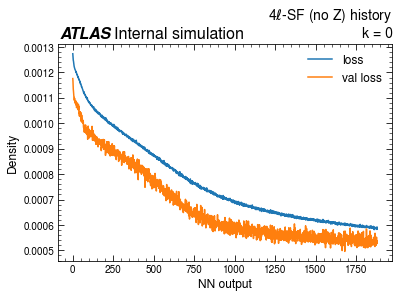

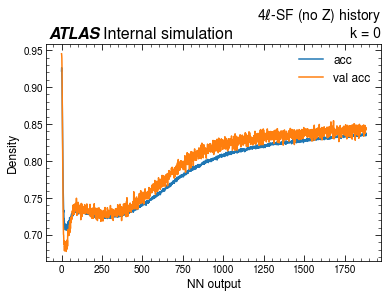

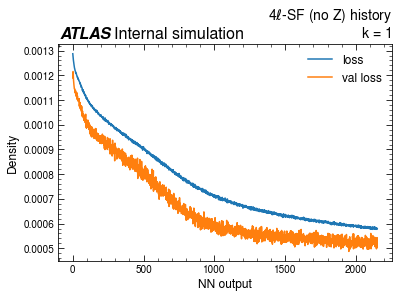

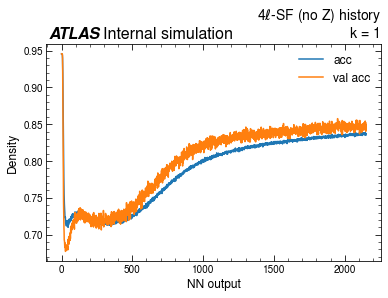

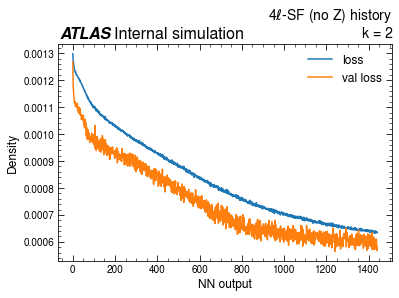

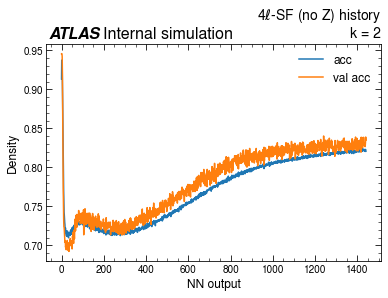

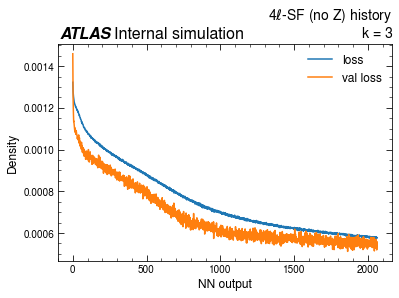

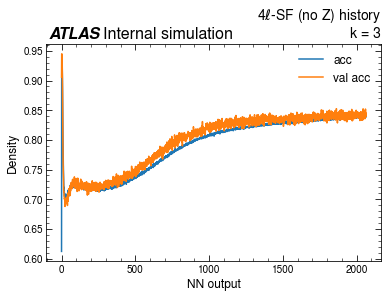

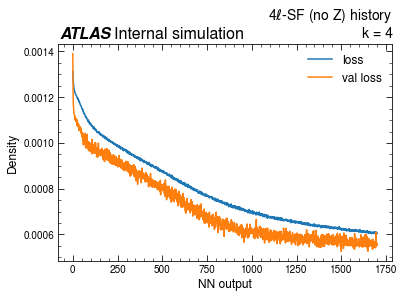

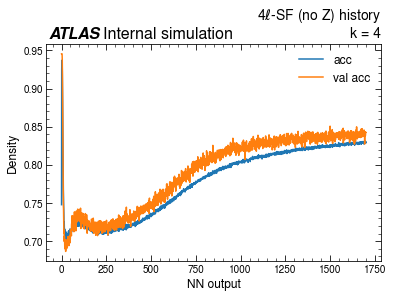

In [25]:
# Generate training history plots
for k in range(K_FOLDS):
    # Load model
    model_dir = 'models/SR_SF_noZ/'
    plot_dir = 'plots/SR_SF_noZ/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    
    with open(model_dir + model_name + '_history.pkl', 'rb') as f:
        history = pickle.load(f)
        
    # Loss
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val loss')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('4$\ell$-SF (no Z) history\nk = ' + str(k), fontsize=14, loc='right')
    
    plot_util.save_fig(plot_dir, model_name + '_loss')
    plt.show()
    
    # Accuracy
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['val_accuracy'], label='val acc')
    
    plt.legend(fontsize=12)
    plt.xlabel('NN output', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    atlasify('Internal simulation', outside=True)
    
    plt.title('4$\ell$-SF (no Z) history\nk = ' + str(k), fontsize=14, loc='right')
    
    plot_util.save_fig(plot_dir, model_name + '_acc')
    plt.show()

In [26]:
nn_out_col = 'nn_out'

combined_data[nn_out_col] = -1

for k in range(K_FOLDS):
    # Load model
    model_dir = 'models/SR_SF_noZ/'
    model_name = 'classifier_abs_wgt_k_' + str(k)
    
    K.clear_session()
    classifier = keras.models.load_model(model_dir + model_name)
    
    # We test classifier k on slice k
    x_test = combined_data[combined_data.k_fold == k][train_feats]
    combined_data.loc[combined_data.k_fold == k, nn_out_col] = classifier.predict(x_test, batch_size=10000)

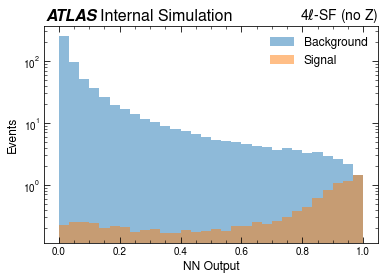

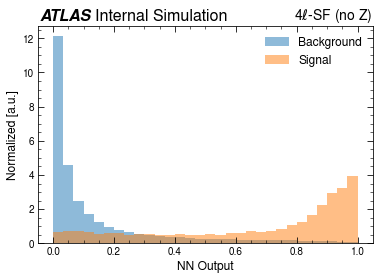

In [27]:
bg_sample = combined_data[combined_data.is_signal == 0]
sig_sample = combined_data[combined_data.is_signal == 1]


plot_util.make_nn_output_plot(bg_sample, sig_sample, 'nn_out', 'Background', 'Signal', 
                              save=True, save_dir='plots/SR_SF_noZ/', save_name='nn_output', 
                              title='4$\ell$-SF (no Z)', log=True)
plot_util.make_nn_output_plot(bg_sample, sig_sample, 'nn_out', 'Background', 'Signal', density=True, 
                              save=True, save_dir='plots/SR_SF_noZ/', save_name='nn_output_density', 
                              title='4$\ell$-SF (no Z)', log=False)

In [30]:
n_cuts = 100

cuts = np.arange(0, 1, 1./n_cuts)
sigs = [-1]*n_cuts

max_sig = -1
max_sig_loc = -1

for i, nn_cut in enumerate(cuts):
    bg_sample = combined_data[(combined_data.is_signal == 0)&(combined_data.nn_out >= nn_cut)]
    sig_sample = combined_data[(combined_data.is_signal == 1)&(combined_data.nn_out >= nn_cut)]

    n_sig = sum(sig_sample.wgt)
    n_bg = sum(bg_sample.wgt)

    sig = util.significance(n_sig, n_bg)
    sigs[i] = sig
    if sig > max_sig:
        max_sig = sig
        max_sig_loc = nn_cut

In [ ]:
# Plot scan
plt.figure(figsize=(6, 4))
plt.plot(cuts, sigs)

plt.axhline(y=max_sig, color='black', ls='--', alpha=0.5)
plt.axvline(x=max_sig_loc, color='black', ls='--', alpha=0.5)

plt.ylabel('Significance', fontsize=14)
plt.xlabel('NN cut', fontsize=14)
plt.title('4$\ell$-DF', loc='right', fontsize=14)

plt.text(min(cuts), min(sigs), 
         'Max: %.2f $\sigma$\nLoc: %.2f'%(max_sig, max_sig_loc),
         fontsize=14)

atlasify('Internal Simulation', outside=True)

plot_util.save_fig('plots/SR_SF_noZ/', 'sig_scan')